# Null Model Parameter & Error Distributions

1. Null param distributions with observed values (red lines)
2. Pooled SD calculation
3. Standardized null param distributions
4. Standardized squared error distributions with Broderick

In [9]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.dirname(os.getcwd()))

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sfp_nsdsyn import two_dimensional_model as model
from sfp_nsdsyn.bootstrapping import (
    pooled_std, standardized_mean,
    calculate_standardized_error_per_param_comparison
)
from sfp_nsdsyn.visualization import plot_2D_model_results as vis2D

with open(os.path.join(os.path.dirname(os.getcwd()), 'config.json')) as f:
    config = json.load(f)

OUTPUT_DIR = config['OUTPUT_DIR']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
PARAMS_2D = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']
ARGS_2D = ['lr', 'eph', 'sub', 'roi']
LR = '0.0005'
MAX_EPOCH = '30000'
VS = 'pRFsize'
N_PERM = 300

nsdsyn_subjs = [f'subj{sn:02d}' for sn in range(1, 9)]
broderick_sns = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subjs = [f'wlsubj{sn:03d}' for sn in broderick_sns]

def perm_batch(perm):
    return f'batch_{(perm // 100) * 100:03d}'

def perm_model_pt(subj, perm):
    return os.path.join(
        OUTPUT_DIR, 'sfp_model', 'results_2D', 'nsdsyn', 'perm', subj,
        perm_batch(perm),
        f'perm-{perm}_model-params_lr-{LR}_eph-{MAX_EPOCH}_sub-{subj}_roi-V1_vs-{VS}.pt')

nsd_model_paths = [
    os.path.join(OUTPUT_DIR, 'sfp_model', 'results_2D', 'nsdsyn',
                 f'model-params_lr-{LR}_eph-{MAX_EPOCH}_sub-{s}_roi-V1_vs-{VS}.pt')
    for s in nsdsyn_subjs]

broderick_model_paths = [
    os.path.join(OUTPUT_DIR, 'sfp_model', 'results_2D', 'broderick',
                 f'model-params_lr-{LR}_eph-{MAX_EPOCH}_sub-{s}_roi-V1_vs-{VS}.pt')
    for s in broderick_subjs]

null_model_paths = [
    perm_model_pt(subj, p)
    for p in range(N_PERM)
    for subj in nsdsyn_subjs]

In [11]:
nsd_df = model.load_all_models(nsd_model_paths, *ARGS_2D)
broderick_df = model.load_all_models(broderick_model_paths, *ARGS_2D)
null_nsd_df = model.load_all_models(null_model_paths, *['sub', 'lr', 'eph', 'roi', 'perm'])
null_nsd_df['perm'] = null_nsd_df['perm'].astype(int)

## 1. Null Parameter Distributions with Observed Values

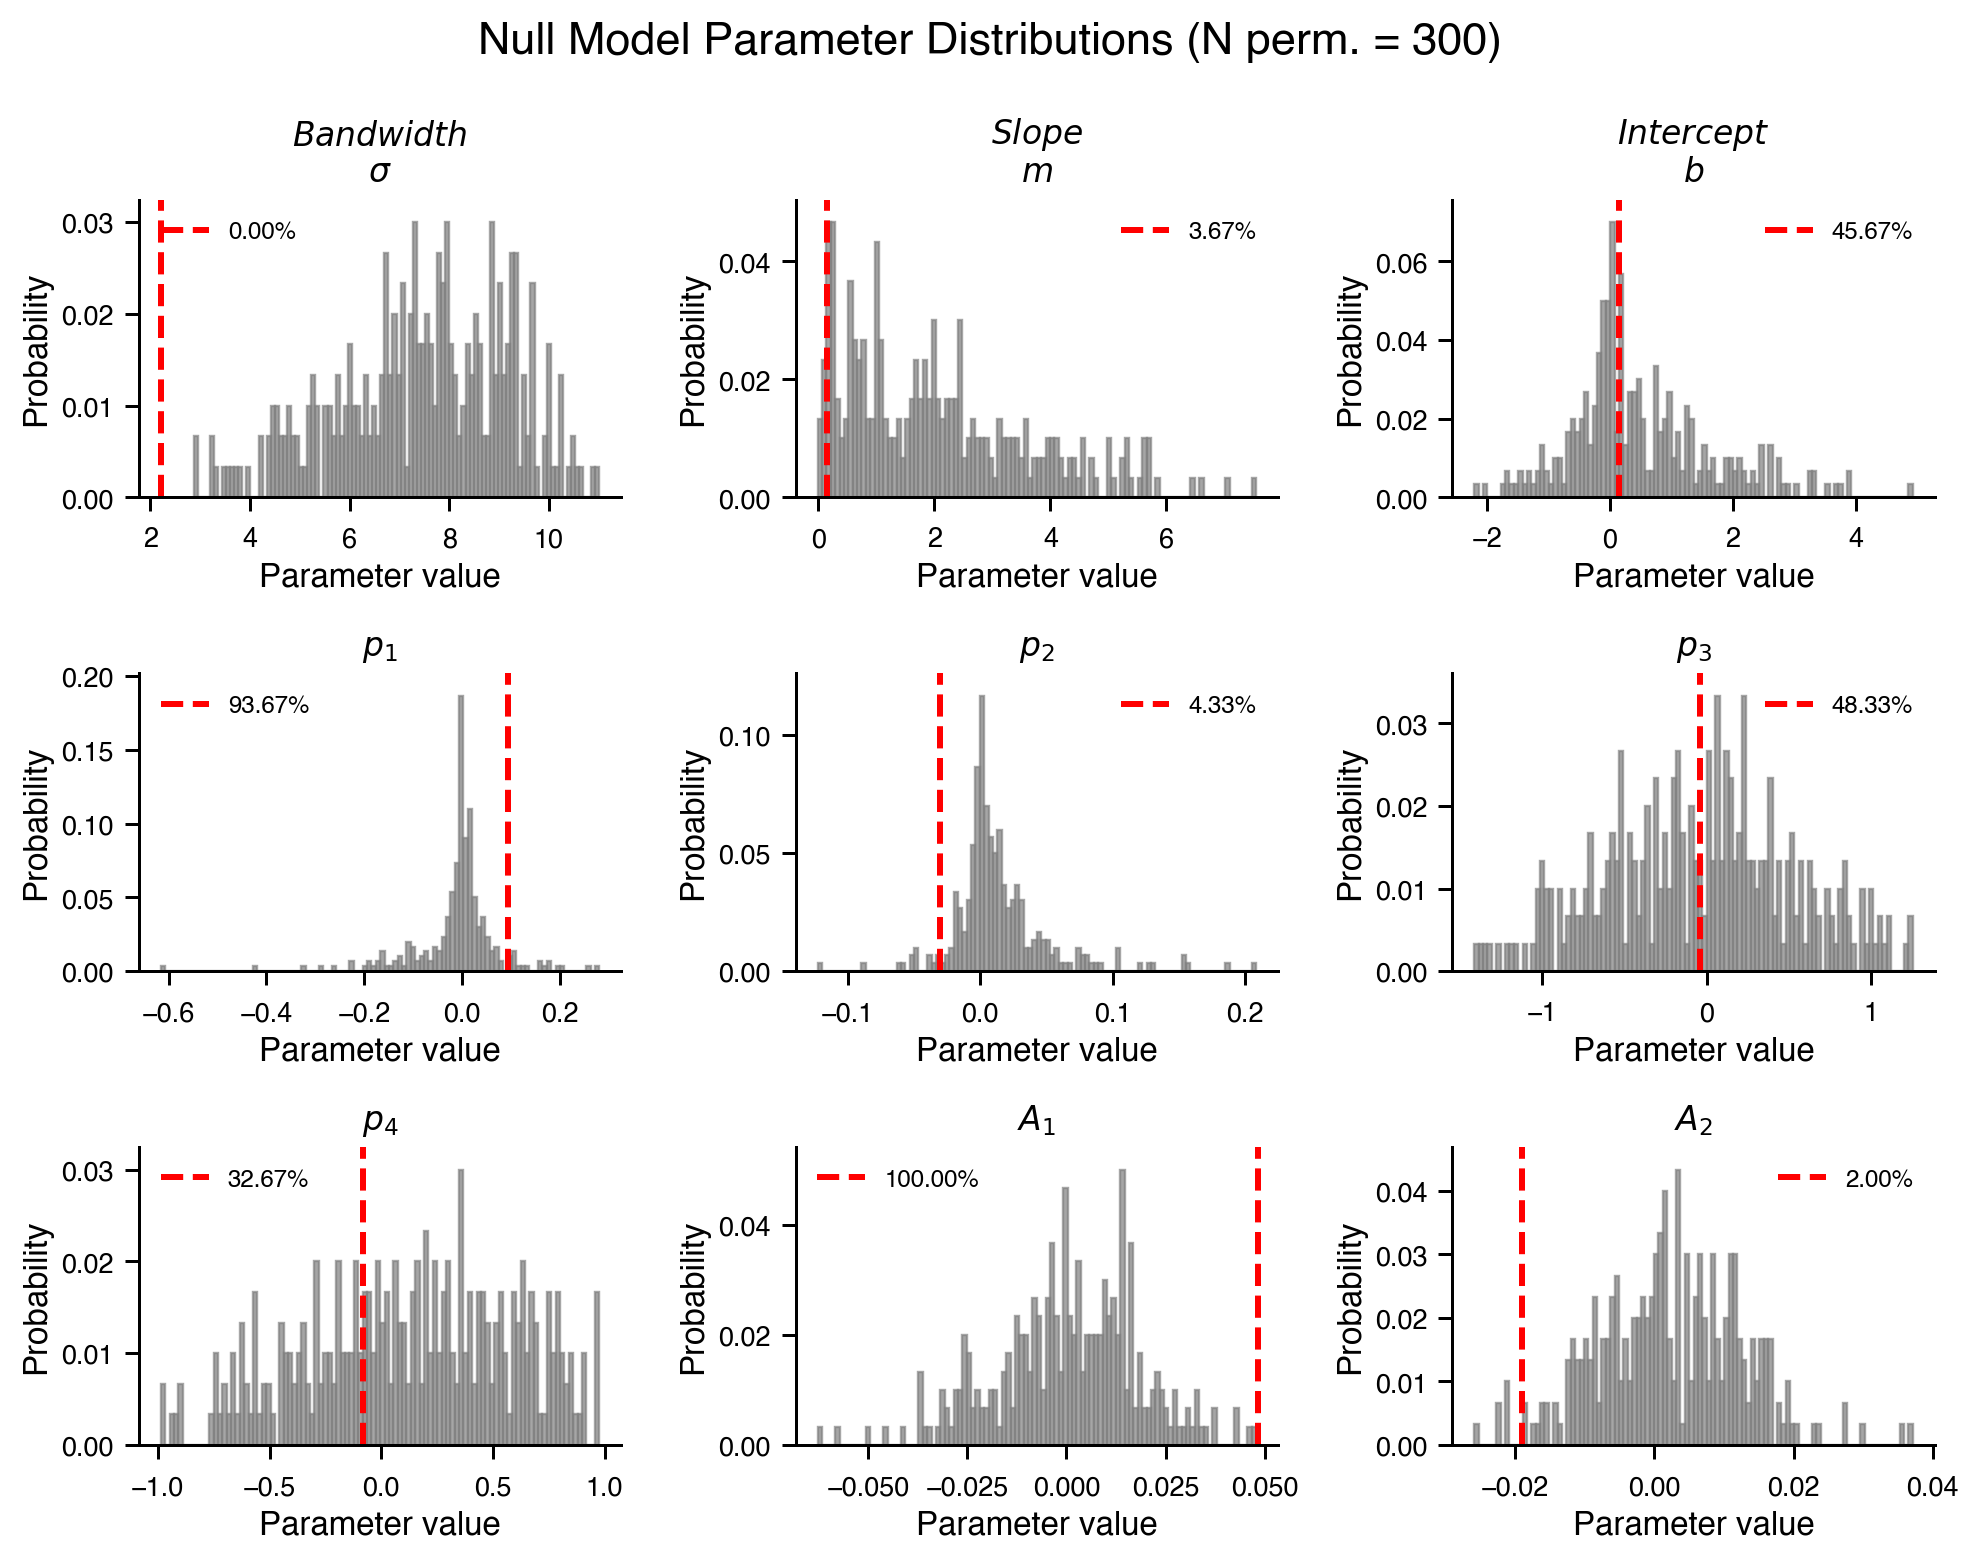

In [12]:
actual_means = nsd_df[PARAMS_2D].mean().to_dict()
null_param_df = null_nsd_df.groupby('perm')[PARAMS_2D].mean().reset_index()

fig, _ = vis2D.plot_null_param_value_distributions(
    null_param_df, actual_means,
    params=PARAMS_2D,
    title=f'Null Model Parameter Distributions (N perm. = {N_PERM})',
    bins=100)

## 2. Pooled SD

In [13]:
nsd_tmp = nsd_df.copy()
broderick_tmp = broderick_df.copy()
nsd_tmp['dset_type'] = 'NSD V1'
broderick_tmp['dset_type'] = 'Broderick et al. V1'
actual_combined = pd.concat([nsd_tmp, broderick_tmp], axis=0)

pooled_sd_df = pooled_std(actual_combined, group_col='dset_type', params=PARAMS_2D)

pooled_sd_df

,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2
0,0.303617,0.052073,0.156767,0.069807,0.032712,0.106258,0.052954,0.031136,0.014144


## 3. Standardized Null Parameter Distributions

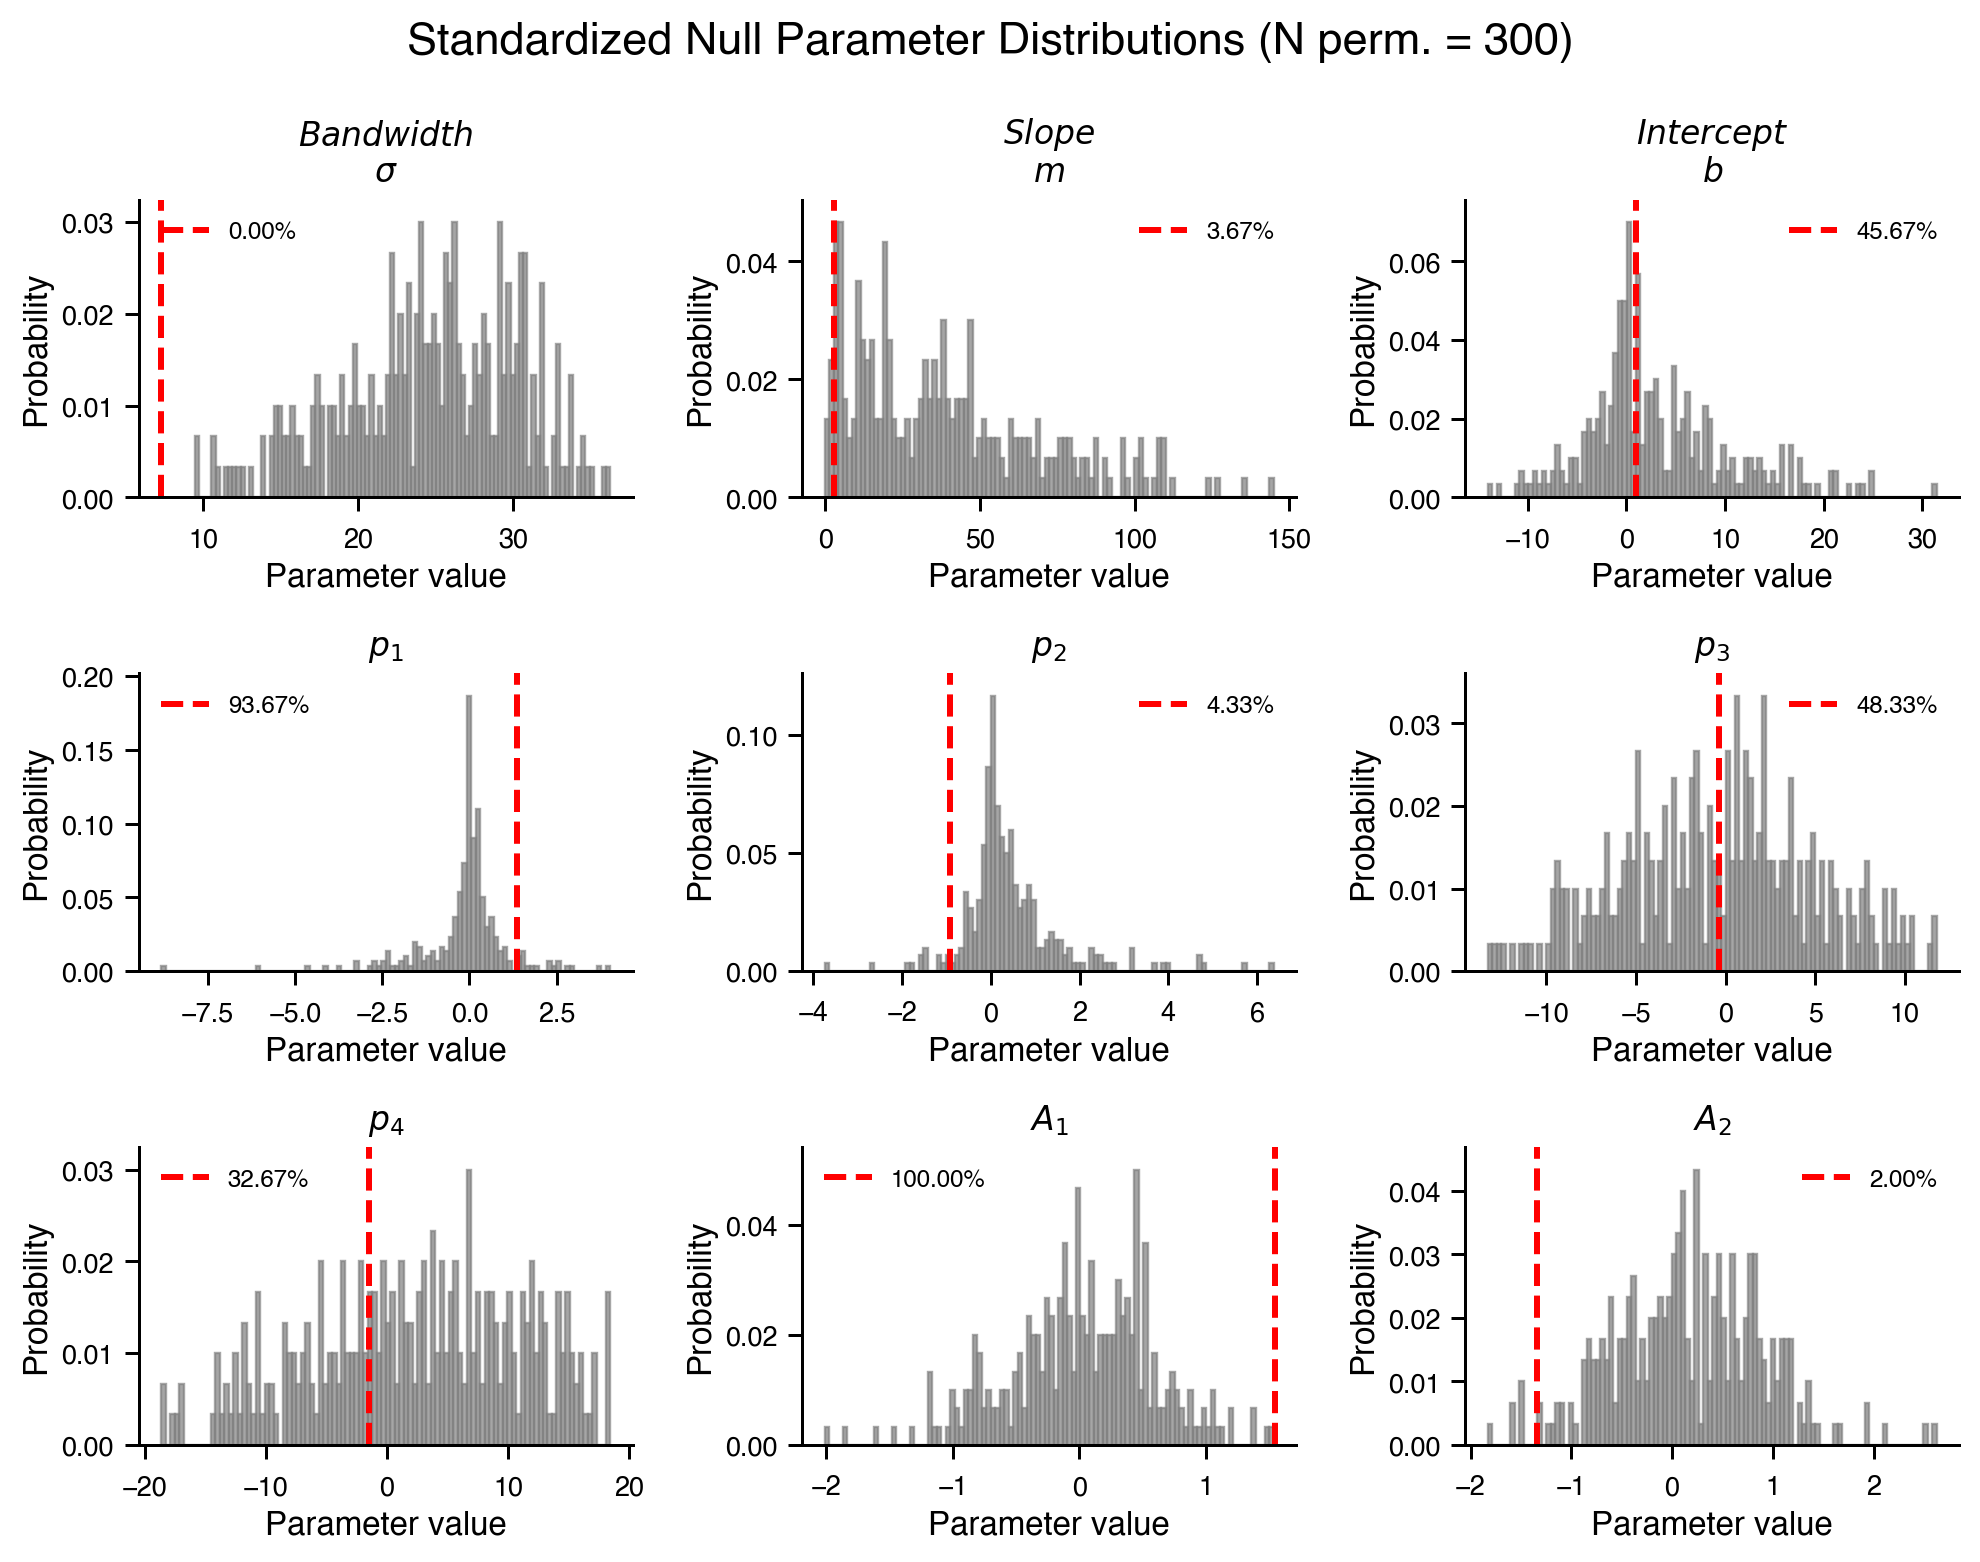

In [14]:
std_actual = standardized_mean(actual_combined, pooled_sd_df, group_col='dset_type', params=PARAMS_2D)
std_nsd_means = std_actual[std_actual['dset_type'] == 'NSD V1'][PARAMS_2D].iloc[0].to_dict()

null_tmp = null_nsd_df.copy()
null_tmp['dset_type'] = 'Null NSD V1'
std_null = standardized_mean(null_tmp, pooled_sd_df, group_col=['dset_type', 'perm'], params=PARAMS_2D)
std_null_param_df = std_null[PARAMS_2D + ['perm']].copy()

fig, _ = vis2D.plot_null_param_value_distributions(
    std_null_param_df, std_nsd_means,
    params=PARAMS_2D,
    title=f'Standardized Null Parameter Distributions (N perm. = {N_PERM})',
    bins=100)

## 3.5 Diagnosing Standardized Squared Error Peak Locations

The standardized squared error for each null permutation is:
$$SE_{param} = \left(\frac{\bar{x}_{null} - \bar{x}_{brod}}{s_{pooled}}\right)^2$$

The peak location depends on how far null means land from Broderick means (numerator) relative to pooled SD (denominator). Below we decompose these components per parameter.

In [16]:
# Raw group means
nsd_means = nsd_df[PARAMS_2D].mean()
brod_means = broderick_df[PARAMS_2D].mean()
null_center = null_param_df[PARAMS_2D].median()  # median of perm means
pooled_sds = pooled_sd_df.iloc[0][PARAMS_2D]

# Build summary table
summary = pd.DataFrame({
    'NSD_mean': nsd_means,
    'Broderick_mean': brod_means,
    'null_median': null_center,
    'pooled_sd': pooled_sds,
    '|null-brod|': np.abs(null_center - brod_means),
    '|null-brod|/pooled_sd': np.abs(null_center - brod_means) / pooled_sds,
    '(|null-brod|/pooled_sd)^2': (np.abs(null_center - brod_means) / pooled_sds) ** 2,
})
summary.index.name = 'param'
summary.round(4)

,NSD_mean,Broderick_mean,null_median,pooled_sd,|null-brod|,|null-brod|/pooled_sd,(|null-brod|/pooled_sd)^2
param,,,,,,,
sigma,2.2139,2.1855,7.5933,0.3036,5.4078,17.8112,317.2384
slope,0.1436,0.1161,1.7772,0.0521,1.6610,31.8980,1017.4834
intercept,0.1487,0.3611,0.2054,0.1568,0.1556,0.9928,0.9857
p_1,0.0942,0.0747,0.0003,0.0698,0.0744,1.0654,1.1352
p_2,-0.0301,-0.0289,0.0062,0.0327,0.0351,1.0734,1.1521
p_3,-0.0377,0.0701,0.0029,0.1063,0.0671,0.6319,0.3992
p_4,-0.0802,-0.0058,0.1566,0.0530,0.1624,3.0666,9.4040
A_1,0.0482,0.0445,0.0009,0.0311,0.0436,1.4007,1.9620
A_2,-0.0190,-0.0051,0.0018,0.0141,0.0069,0.4895,0.2396


In [ ]:
# Why is p_4's null median (0.157) far from zero?
# Check: do individual null subjects also show positive p_4, or is it a mean artifact?
phase_params = ['p_1', 'p_2', 'p_3', 'p_4']

# Per-subject null means (averaged over permutations)
null_subj_means = null_nsd_df.groupby('sub')[phase_params].mean()

# Per-permutation null means (averaged over subjects) — this is what enters the SE calculation
null_perm_means = null_nsd_df.groupby('perm')[phase_params].mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))
null_subj_means[phase_params].boxplot(ax=axes[0])
axes[0].axhline(0, color='gray', ls='--', lw=0.8)
axes[0].set_title('Null subject means (averaged over perms)')
axes[0].set_ylabel('Parameter value')

null_perm_means[phase_params].boxplot(ax=axes[1])
axes[1].axhline(0, color='gray', ls='--', lw=0.8)
axes[1].set_title('Null permutation means (averaged over subjects)')
axes[1].set_ylabel('Parameter value')
fig.tight_layout()

In [ ]:
# Which subject(s) drive the p_4 bias?
null_subj_perm = null_nsd_df.groupby(['sub', 'perm'])[phase_params].mean().reset_index()
fig, ax = plt.subplots(figsize=(6, 3.5))
for subj in nsdsyn_subjs:
    subj_data = null_subj_perm[null_subj_perm['sub'] == subj]['p_4']
    ax.hist(subj_data, bins=30, alpha=0.4, label=subj)
ax.axvline(0, color='k', ls='--', lw=0.8)
ax.set_xlabel('p_4 (per-permutation mean)')
ax.set_title('p_4 null distribution by subject')
ax.legend(fontsize=7, ncol=2)
fig.tight_layout()

In [17]:
# Standardized means comparison
std_brod_means = std_actual[std_actual['dset_type'] == 'Broderick et al. V1'][PARAMS_2D].iloc[0]
std_null_center = std_null_param_df[PARAMS_2D].median()

std_summary = pd.DataFrame({
    'std_NSD_mean': pd.Series(std_nsd_means),
    'std_Broderick_mean': std_brod_means,
    'std_null_median': std_null_center,
    '|std_null - std_brod|': np.abs(std_null_center.values - std_brod_means.values),
}, index=PARAMS_2D)
std_summary.index.name = 'param'
std_summary.round(4)

,std_NSD_mean,std_Broderick_mean,std_null_median,|std_null - std_brod|
param,,,,
sigma,7.2916,7.1981,25.0093,17.8112
slope,2.7580,2.2302,34.1282,31.8980
intercept,0.9486,2.3033,1.3105,0.9928
p_1,1.3498,1.0698,0.0044,1.0654
p_2,-0.9212,-0.8824,0.1909,1.0734
p_3,-0.3545,0.6593,0.0274,0.6319
p_4,-1.5140,-0.1089,2.9577,3.0666
A_1,1.5479,1.4293,0.0286,1.4007
A_2,-1.3437,-0.3632,0.1263,0.4895


### Interpretation

The `(|null-brod|/pooled_sd)^2` column predicts where each parameter's null distribution peaks in Section 4.

| Group | Params | Predicted peak | Reason |
|-------|--------|---------------|--------|
| Very high | sigma, slope | ~300-1000 | Shuffling destroys SF tuning, pushing null means far from Broderick |
| Moderate | p_4 | ~9.4 | Null median (0.157) is far from Broderick (-0.006) relative to pooled SD (0.053) |
| Near 1 | p_1, p_2, A_1, intercept | ~1-2 | Null center lands ~1 pooled SD from Broderick |
| Below 1 | p_3, A_2 | ~0.2-0.4 | Null center is close to Broderick relative to pooled SD |

**Why p_4 has a systematic positive bias under the null:**
Why p_4's null median is ~0.157 (far from zero):           
                                                             
  The root cause is the stimulus design geometry. In the     
  model, p_4 multiplies `cos(4*(local_ori - angle))`, which evaluates to:                                              
  - Exactly +1 for annulus and pinwheel classes (12 classes) 
  - Exactly -1 for forward-spiral and reverse-spiral classes 
  (12 classes)                                               
  - ~0 for mixture classes (4 classes)                       
                                                             
  The key asymmetry: spiral classes have higher mean betas
  (2.86) than annulus/pinwheel (2.51). So in the real data,
  the cos4_rel = -1 conditions are paired with larger
  responses, yielding a negative observed p_4 (mean: -0.08).

  When class labels are shuffled, this pairing is broken. The
   bimodal structure of the basis (+1/-1) means any random
  shuffling creates small imbalances that the optimizer
  absorbs into p_4. The consistent positive bias (0.07–0.17
  across all 8 subjects) arises because shuffling removes the
   real negative association, and the optimizer settles on a
  slight positive value instead. This is not an
  initialization artifact — init is [0, 0.1] but the null
  mean overshoots to 0.126.

  This positive null median, combined with Broderick's p_4
  being near zero (-0.006) and a small pooled SD (0.053),
  produces the elevated standardized squared error peak at
  ~9.4.

**On replication:** The null peak location does not determine replication. What matters is whether the *observed* NSD error (red line in Section 4) falls in the left tail of the null — meaning the real data is closer to Broderick than shuffled data.

## 4. Standardized Squared Error Distributions with Broderick

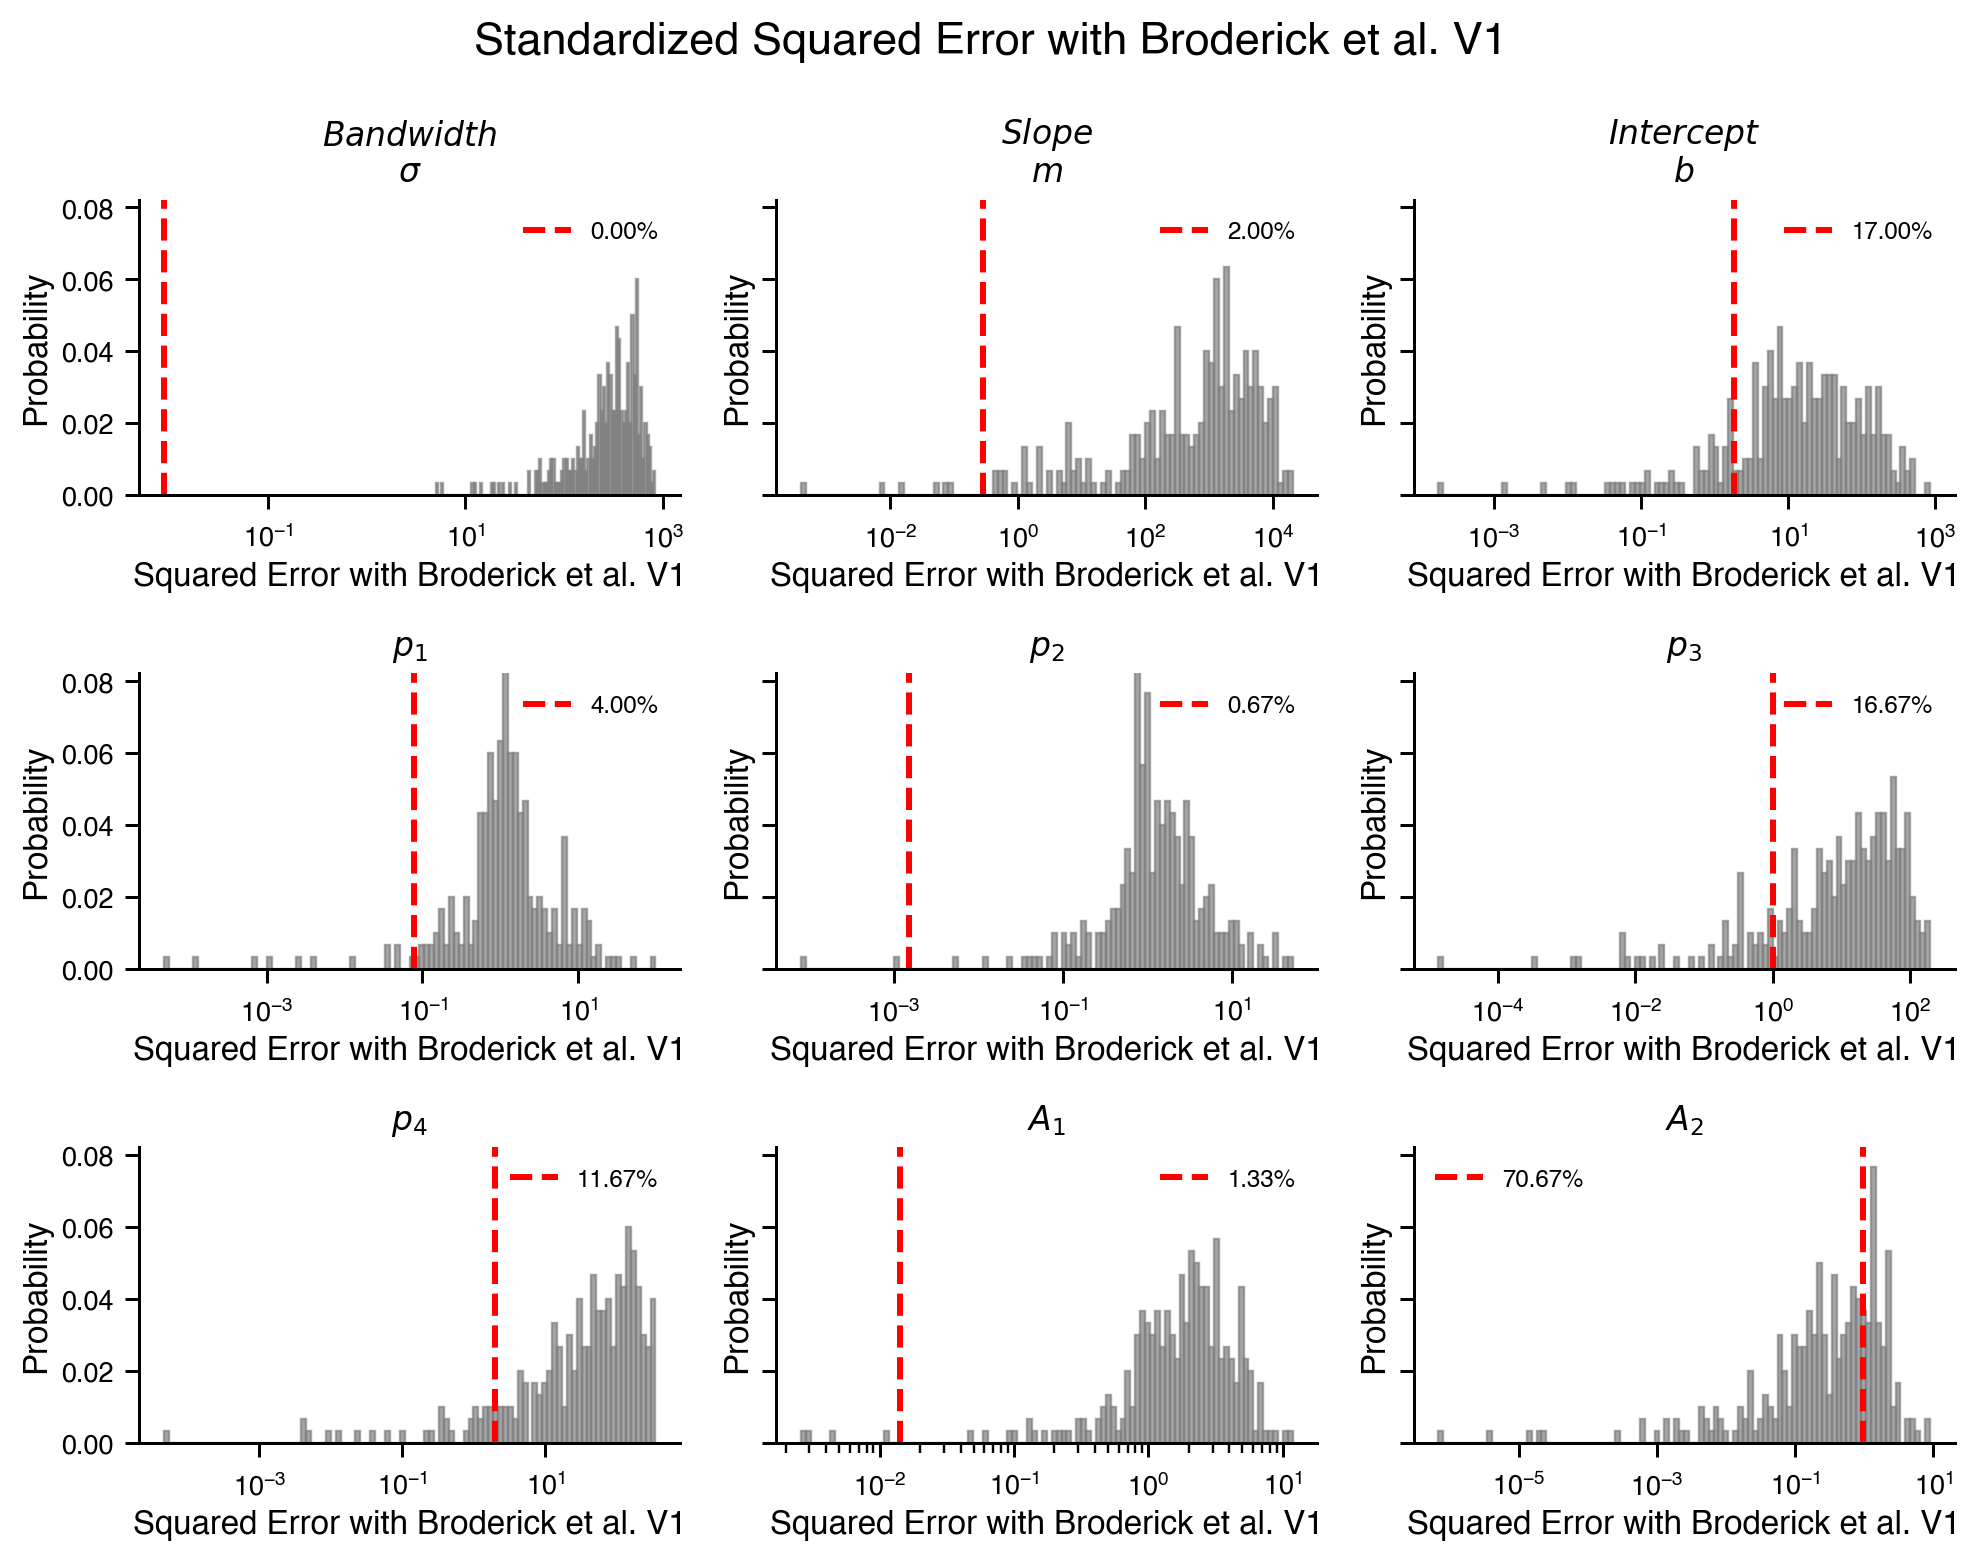

In [15]:
actual_errors, null_errors_df, _ = calculate_standardized_error_per_param_comparison(
    nsd_df, broderick_df, null_nsd_df, params=PARAMS_2D, standardize=True)

fig, _ = vis2D.plot_null_distribution_per_param(
    null_errors_df, actual_errors,
    params=PARAMS_2D,
    title='Standardized Squared Error with Broderick et al. V1',
    bins=100,
    logscale=True)